
# Meme Virality Across Platforms: Notebook
**Group 23: Hanna , Lingchen Chen, Feihong Tian, Akshara Bruno** 

**Research question:**  
*How do the visual template (meme format) and caption framing jointly influence cross-platform virality and sentiment?*

This notebook is designed to:

1. Collect meme data from Reddit and Bluesky.  
2. Preprocess images and captions.  
3. Cluster meme templates based on image content.  
4. Analyze caption framing and sentiment.  
5. Model virality as a function of template, caption, and platform.  
6. Produce the main figures and tables.



## 0. How to run this notebook

1. Create a folder structure like:

```
project_root/
  data/
    raw/
    processed/
  images/
  models/
  notebook.ipynb
```

2. Place the cleaned datasets used in the paper into `data/processed/`  
   (e.g., `reddit_memes.csv`, `bluesky_memes.csv`).

3. (Optional) To re-scrape data from the APIs, follow the instructions in Section 2.

4. Run all cells from top to bottom.

If some external APIs or models cannot be accessed (e.g., CLIP model download),  
the corresponding cells are clearly marked so you can skip them and still see the precomputed results.


## 1. Imports and global configuration

In [4]:
!pip install -r requirements.txt

  Using cached praw-7.8.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached prawcore-2.4.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached websocket_client-1.9.0-py3-none-any.whl.metadata (8.3 kB)
Using cached praw-7.8.1-py3-none-any.whl (189 kB)
Using cached prawcore-2.4.0-py3-none-any.whl (17 kB)
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
Using cached websocket_client-1.9.0-py3-none-any.whl (82 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [praw]


In [2]:
# Standard libraries
import os
import json
import math
import random
from pathlib import Path
from datetime import datetime

# Data & analysis
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Machine learning / embeddings / clustering
try:
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
except ImportError:
    print("scikit-learn is not installed. Install it to enable clustering and t-SNE visualizations.")

# Deep learning / CLIP (for image embeddings)
try:
    import torch
    from PIL import Image
    from transformers import CLIPProcessor, CLIPModel
except ImportError:
    print("torch / transformers / pillow not installed. Install them to enable image embeddings.")

# NLP
try:
    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
except ImportError:
    print("nltk not installed. Install it to enable VADER sentiment analysis.")

# Global paths
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGES_DIR = PROJECT_ROOT / "images"

for p in [DATA_DIR, RAW_DIR, PROCESSED_DIR, IMAGES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)


/Users/aksharabruno/Documents/M Sc/VU/Social Web/Meme Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /Users/aksharabruno/Documents/M Sc/VU/Social Web/Meme Project



## 2. Data collection (overview)

We collect meme posts from:

- **Reddit** – using the Reddit API (e.g. PRAW or Pushshift-like interface).  
- **Bluesky** – using the ATProto API.

For each platform we aim to obtain:

- Post ID, author, timestamp  
- Caption / title text  
- Image URL(s)  
- Engagement statistics (upvotes / likes, comments / replies, reposts)  
- Platform indicator and, for Reddit, subreddit information  

In practice, the actual scraping code may be placed in a separate script to avoid  
API credential issues inside the notebook. Here we provide a minimal example skeleton.


### 2.1 Reddit scraping skeleton (to run once, offline)

We use PRAW (Python Reddit API Wrapper) to collect data from Reddit. The subreddits we target are 'memes', 'dankmemes', 'AdviceAnimals' and 'MemeEconomy' (to be changed later). Reddit allows 60 requests per minute. PRAW handles this automatically. The collected data gets stored in reddit_memes.csv


In [5]:
import praw
import pandas as pd
from datetime import datetime

# Initialize Reddit instance
reddit = praw.Reddit(
    client_id='Dhu5BDkroWpRBQ',
    client_secret='ojQeyIZ793E7I6fRFILOiLdJzdGNcg',
    user_agent='meme_research_v1.0'
)

# Target meme subreddits
subreddits = ['memes', 'dankmemes', 'AdviceAnimals', 'MemeEconomy']

meme_data = []

for sub_name in subreddits:
    subreddit = reddit.subreddit(sub_name)
    
    # Get top posts from the past month
    for post in subreddit.top(time_filter='month', limit=1000):
        if post.url.endswith(('.jpg', '.png', '.gif', '.jpeg')):
            meme_data.append({
                'post_id': post.id,
                'author': str(post.author) if post.author else '[deleted]',
                'timestamp': datetime.fromtimestamp(post.created_utc),
                'caption_title': post.title,
                'image_url': post.url,
                'upvotes': post.score,
                'upvote_ratio': post.upvote_ratio,
                'num_comments': post.num_comments,
                'platform': 'Reddit',
                'subreddit': sub_name,
                'permalink': f"https://reddit.com{post.permalink}"
            })

df = pd.DataFrame(meme_data)
df.to_csv('reddit_memes.csv', index=False)

print(f"Collected {len(meme_data)} memes from Reddit")
print(f"Data saved to reddit_memes.csv")

Collected 711 memes from Reddit
Data saved to reddit_memes.csv


Following is the script to download the actual separately using the URLs. The images get stored in directory images/reddit_images.

In [6]:
import requests
from pathlib import Path

img_dir = Path('images/reddit_images')
img_dir.mkdir(exist_ok=True)

for idx, row in df.iterrows():
    try:
        response = requests.get(row['image_url'], timeout=10)
        if response.status_code == 200:
            ext = row['image_url'].split('.')[-1]
            with open(img_dir / f"{row['post_id']}.{ext}", 'wb') as f:
                f.write(response.content)
    except Exception as e:
        print(f"Failed to download {row['post_id']}: {e}")

### 2.2 Bluesky scraping skeleton (to run once, offline)

In [4]:
import sys
!{sys.executable} -m pip install atproto


[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [24]:
from atproto import Client

client = Client()

# Use your HANDLE with @ prefix
HANDLE = "@linnnnlnl.bsky.social"  # Note: add @ at the beginning
PASSWORD = "qzvj-z6d2-mcju-2s6h"

print("Trying to login...")

try:
    session = client.login(EMAIL, PASSWORD)  # or HANDLE or HANDLE_SIMPLE
    print(f"✅ SUCCESS! Logged in as: {session.handle}")
    print(f"   Your DID is: {session.did}")
except Exception as e:
    print(f"❌ Failed: {e}")

# Now that we're logged in, let's understand post structure
from atproto import Client, models

# We already have a logged-in client 
# Let's test the search with the authenticated client
params = models.AppBskyFeedSearchPosts.Params(
    q="change my mind",
    limit=3  # Get 3 posts to see variety
)

feed = client.app.bsky.feed.search_posts(params)

print(f"\n📊 Found {len(feed.posts)} posts for 'change my mind'")

# Look at each post structure
for i, post in enumerate(feed.posts):
    print(f"\n{'='*60}")
    print(f"POST {i+1}")
    print('='*60)
    
    # Basic info
    print(f"URI (unique ID): {post.uri}")
    print(f"Author: {post.author.handle}")
    
    # Text content
    if hasattr(post, 'record'):
        text = post.record.text[:150]
        print(f"Text: {text}..." if len(post.record.text) > 150 else f"Text: {post.record.text}")
        print(f"Created at: {post.record.created_at}")
    
    # Check for images
    has_images = False
    if hasattr(post, 'embed') and hasattr(post.embed, 'images'):
        image_count = len(post.embed.images)
        print(f"Has images: YES ({image_count} images)")
        for img_idx, img in enumerate(post.embed.images[:2]):  # Show first 2
            if hasattr(img, 'image'):
                print(f"  Image {img_idx+1}: {img.image}")
        has_images = True
    else:
        print("Has images: NO")
    
    # Engagement metrics
    print(f"Likes: {getattr(post, 'like_count', 0)}")
    print(f"Reposts: {getattr(post, 'repost_count', 0)}")
    print(f"Replies: {getattr(post, 'reply_count', 0)}")
    
    # Quick summary for our project
    print(f"\n✅ FOR OUR PROJECT: This post has {'images' if has_images else 'NO images'} and text for analysis")

Trying to login...
✅ SUCCESS! Logged in as: linnninl.bsky.social
   Your DID is: did:plc:4pbmtyc6wfxwifsfemuldrdf

📊 Found 3 posts for 'change my mind'

POST 1
URI (unique ID): at://did:plc:lolmxugilgmvi4y23nq6qrry/app.bsky.feed.post/3m744m45ohc2w
Author: angrybarks.club
Text: Low on cash for MFF. Gonna set up a table outside that reads, "I do NOT support the current thing. CHANGE MY MIND," and for $5 you can dunk on me on v...
Created at: 2025-12-03T18:47:15.738Z
Has images: NO
Likes: 5
Reposts: 0
Replies: 1

✅ FOR OUR PROJECT: This post has NO images and text for analysis

POST 2
URI (unique ID): at://did:plc:pc2pklzbc2u5v3qsrc2se5kk/app.bsky.feed.post/3m744j4ocxs25
Author: solarshea.bsky.social
Text: 
Created at: 2025-12-03T18:45:35.619Z
Has images: YES (1 images)
Likes: 0
Reposts: 0
Replies: 0

✅ FOR OUR PROJECT: This post has images and text for analysis

POST 3
URI (unique ID): at://did:plc:syijvilo5leepzzuy7d3bdkr/app.bsky.feed.post/3m743t2nahc26
Author: collaredclown.bsky.socia

In [26]:
# STEP 3: Inspect the image post in detail
print("🔍 Examining the image post (POST 2) in detail...")

# Get the post with images
image_post = None
for post in feed.posts:
    if hasattr(post, 'embed') and hasattr(post.embed, 'images') and post.embed.images:
        image_post = post
        break

if image_post:
    print(f"✅ Found image post from: {image_post.author.handle}")
    
    # Look at the embed structure
    print(f"\n📁 Embed type: {type(image_post.embed).__name__}")
    
    # Check all images
    print(f"Number of images: {len(image_post.embed.images)}")
    
    for i, img in enumerate(image_post.embed.images):
        print(f"\n🖼️ Image {i+1}:")
        
        # Get image URL
        if hasattr(img, 'image'):
            print(f"  Image URL: {img.image}")
            
            # Try to get the actual image link
            # Bluesky images are usually stored in a specific format
            # Let's see if we can construct a viewable URL
            if hasattr(img.image, 'ref'):
                ref = img.image.ref
                print(f"  Image ref: {ref}")
                
                # Try to get the link if it exists
                if hasattr(ref, 'link'):
                    print(f"  Direct link: {ref.link}")
        
        # Get alt text (if available)
        if hasattr(img, 'alt'):
            print(f"  Alt text: {img.alt[:100] if img.alt else 'None'}")
        
        # Get image dimensions
        if hasattr(img, 'aspect_ratio'):
            print(f"  Aspect ratio: {img.aspect_ratio}")
    
    # Let's see if we can get a preview image
    print(f"\n🔗 Can we get a preview?")
    if hasattr(image_post.embed.images[0], 'thumb'):
        print(f"  Thumbnail available: {image_post.embed.images[0].thumb}")
    
    # Try to construct a viewable URL
    print(f"\n🌐 Constructing viewable image URL...")
    if hasattr(image_post.embed.images[0], 'image'):
        img_obj = image_post.embed.images[0].image
        # Bluesky images are usually at: https://cdn.bsky.app/img/...
        # Let's see what attributes the image object has
        print(f"  Image object attributes: {[attr for attr in dir(img_obj) if not attr.startswith('_')]}")
        
        if hasattr(img_obj, 'ref'):
            ref = img_obj.ref
            if hasattr(ref, 'link'):
                print(f"  Full image link: {ref.link}")
                print(f"  Try opening: https://cdn.bsky.app/img/...")
else:
    print("❌ No image post found in this batch")

🔍 Examining the image post (POST 2) in detail...
✅ Found image post from: solarshea.bsky.social

📁 Embed type: View
Number of images: 1

🖼️ Image 1:
  Alt text: Photo of a printed sign that says "The NASA Goddard Library is a national treasure and is the corner
  Aspect ratio: height=678 width=586 py_type='app.bsky.embed.defs#aspectRatio'

🔗 Can we get a preview?
  Thumbnail available: https://cdn.bsky.app/img/feed_thumbnail/plain/did:plc:pc2pklzbc2u5v3qsrc2se5kk/bafkreidiha5lsdbqxbif5xiysel4nass3azjej2avt26jnkdr7nncjo2zq@jpeg

🌐 Constructing viewable image URL...


In [25]:
# STEP 2.5: Look at the raw post structure
if feed.posts:
    post = feed.posts[0]
    
    print("\n📋 POST OBJECT ATTRIBUTES:")
    print("-" * 40)
    
    # List all attributes of the post object
    attributes = [attr for attr in dir(post) if not attr.startswith('_')]
    for attr in attributes:
        value = getattr(post, attr)
        print(f"{attr}: {type(value).__name__}")
    
    print("\n🔍 RECORD (text content) ATTRIBUTES:")
    print("-" * 40)
    if hasattr(post, 'record'):
        record_attrs = [attr for attr in dir(post.record) if not attr.startswith('_')]
        for attr in record_attrs[:10]:  # First 10
            print(f"  {attr}")
    
    print("\n💡 KEY FINDING:")
    if hasattr(post, 'embed'):
        print("Post has 'embed' attribute which contains images")
    else:
        print("Post has NO 'embed' attribute - may not contain images")


📋 POST OBJECT ATTRIBUTES:
----------------------------------------
author: ProfileViewBasic
bookmark_count: int
cid: str
construct: method
copy: method
debug: NoneType
dict: method
embed: NoneType
from_orm: method
indexed_at: str
json: method
labels: list
like_count: int
model_computed_fields: dict
model_config: dict
model_construct: method
model_copy: method
model_dump: method
model_dump_json: method
model_extra: dict
model_fields: dict
model_fields_set: set
model_json_schema: method
model_parametrized_name: method
model_post_init: method
model_rebuild: method
model_validate: method
model_validate_json: method
model_validate_strings: method
parse_file: method
parse_obj: method
parse_raw: method
py_type: str
quote_count: int
record: Record
reply_count: int
repost_count: int
schema: method
schema_json: method
threadgate: NoneType
update_forward_refs: method
uri: str
validate: method
viewer: ViewerState

🔍 RECORD (text content) ATTRIBUTES:
----------------------------------------
  cons

/var/folders/8n/x4g3h5bs73s488h40mxljt_c0000gn/T/ipykernel_2147/2603888816.py:11: PydanticDeprecatedSince211: Accessing the 'model_computed_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  value = getattr(post, attr)
/var/folders/8n/x4g3h5bs73s488h40mxljt_c0000gn/T/ipykernel_2147/2603888816.py:11: PydanticDeprecatedSince211: Accessing the 'model_fields' attribute on the instance is deprecated. Instead, you should access this attribute from the model class. Deprecated in Pydantic V2.11 to be removed in V3.0.
  value = getattr(post, attr)


In [27]:
# STEP 1: Focused collection of two meme templates
import time
import pandas as pd
from datetime import datetime

print("🎯 FOCUSED DATA COLLECTION FOR TWO MEME TEMPLATES")
print("=================================================")

# Our two target meme templates
TARGET_TEMPLATES = ["change my mind", "expanding brain"]

all_meme_data = []

for template in TARGET_TEMPLATES:
    print(f"\n🔍 Searching for: '{template}' meme")
    
    # We'll try different search variations to get more results
    search_variations = [
        f"{template} meme",
        template,
        f"{template} template",
        f"#{template.replace(' ', '')}meme"
    ]
    
    template_posts = []
    
    for search_query in search_variations[:2]:  # Try first 2 variations
        print(f"  Using query: '{search_query}'")
        
        params = models.AppBskyFeedSearchPosts.Params(
            q=search_query,
            limit=25  # Get more posts per query
        )
        
        try:
            feed = client.app.bsky.feed.search_posts(params)
            
            if feed and hasattr(feed, 'posts'):
                print(f"    Found {len(feed.posts)} total posts")
                
                image_count = 0
                for post in feed.posts:
                    # Check if post has images
                    has_image = hasattr(post, 'embed') and hasattr(post.embed, 'images') and post.embed.images
                    
                    if has_image:
                        # Extract image URL
                        image_url = None
                        try:
                            if (post.embed.images[0].image and 
                                hasattr(post.embed.images[0].image, 'ref') and 
                                hasattr(post.embed.images[0].image.ref, 'link')):
                                image_url = str(post.embed.images[0].image.ref.link)
                        except:
                            # Try alternative method
                            if hasattr(post.embed.images[0], 'thumb'):
                                thumb_url = post.embed.images[0].thumb
                                # Convert thumbnail to full size
                                image_url = thumb_url.replace('feed_thumbnail', 'feed_fullsize')
                        
                        if image_url:
                            # Extract data for our analysis
                            post_data = {
                                'platform': 'bluesky',
                                'meme_template': template,
                                'search_query': search_query,
                                'post_id': post.uri,
                                'author_handle': post.author.handle,
                                'author_display': post.author.display_name if hasattr(post.author, 'display_name') else '',
                                'caption': getattr(post.record, 'text', ''),
                                'alt_text': post.embed.images[0].alt if hasattr(post.embed.images[0], 'alt') else '',
                                'image_url': image_url,
                                'likes': getattr(post, 'like_count', 0),
                                'reposts': getattr(post, 'repost_count', 0),
                                'replies': getattr(post, 'reply_count', 0),
                                'created_at': getattr(post.record, 'created_at', ''),
                                'indexed_at': getattr(post, 'indexed_at', ''),
                                'post_url': f"https://bsky.app/profile/{post.author.handle}/post/{post.uri.split('/')[-1]}"
                            }
                            
                            template_posts.append(post_data)
                            image_count += 1
                
                print(f"    Found {image_count} posts with images")
                
            time.sleep(1)  # Rate limiting
            
        except Exception as e:
            print(f"    Error with query '{search_query}': {e}")
            continue
    
    # Add to overall collection
    all_meme_data.extend(template_posts)
    print(f"📊 Total for '{template}': {len(template_posts)} meme posts with images")

# Create DataFrame
if all_meme_data:
    df_focused = pd.DataFrame(all_meme_data)
    
    print(f"\n🎉 COLLECTION COMPLETE!")
    print(f"Total meme posts collected: {len(df_focused)}")
    print(f"\nBreakdown by template:")
    print(df_focused['meme_template'].value_counts())
    
    # Save the data
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    output_file = PROCESSED_DIR / f"focused_memes_{timestamp}.csv"
    df_focused.to_csv(output_file, index=False, encoding='utf-8')
    print(f"\n💾 Saved to: {output_file}")
    
    # Display sample
    print("\n📋 SAMPLE DATA:")
    print(df_focused[['meme_template', 'author_handle', 'caption', 'likes', 'reposts']].head(5))
    
else:
    print("\n❌ No data collected. Need to adjust search strategy.")

🎯 FOCUSED DATA COLLECTION FOR TWO MEME TEMPLATES

🔍 Searching for: 'change my mind' meme
  Using query: 'change my mind meme'
    Found 25 total posts
    Found 18 posts with images
  Using query: 'change my mind'
    Found 24 total posts
    Found 2 posts with images
📊 Total for 'change my mind': 20 meme posts with images

🔍 Searching for: 'expanding brain' meme
  Using query: 'expanding brain meme'
    Found 25 total posts
    Found 18 posts with images
  Using query: 'expanding brain'
    Found 25 total posts
    Found 8 posts with images
📊 Total for 'expanding brain': 26 meme posts with images

🎉 COLLECTION COMPLETE!
Total meme posts collected: 46

Breakdown by template:
meme_template
expanding brain    26
change my mind     20
Name: count, dtype: int64

💾 Saved to: /Users/chenlingchen/the social web/data/processed/focused_memes_20251203_2013.csv

📋 SAMPLE DATA:
    meme_template                    author_handle  \
0  change my mind       jakepaulsartre.bsky.social   
1  change my 

In [28]:
# STEP 2: Download images for our two meme templates
import requests
from PIL import Image
import io

def download_meme_images_focused(df):
    """Download images for our focused dataset"""
    print("\n📥 DOWNLOADING MEME IMAGES")
    print("==========================")
    
    download_count = 0
    error_count = 0
    
    for idx, row in df.iterrows():
        try:
            # Create unique filename
            template_short = row['meme_template'].replace(' ', '_')[:15]
            author_short = row['author_handle'].replace('.bsky.social', '').replace('.', '_')[:10]
            filename = f"{template_short}_{author_short}_{idx}.jpg"
            filepath = IMAGES_DIR / filename
            
            # Skip if already downloaded
            if filepath.exists():
                print(f"  ✓ Already exists: {filename}")
                df.at[idx, 'image_path'] = str(filepath)
                download_count += 1
                continue
            
            # Download image
            if pd.notna(row['image_url']) and row['image_url']:
                print(f"  Downloading {filename}...")
                
                headers = {
                    'User-Agent': 'Meme Research Project (Academic)'
                }
                
                response = requests.get(row['image_url'], headers=headers, timeout=15)
                
                if response.status_code == 200:
                    # Save the image
                    with open(filepath, 'wb') as f:
                        f.write(response.content)
                    
                    # Verify it's a valid image
                    try:
                        img = Image.open(filepath)
                        img.verify()  # Verify it's a valid image
                        
                        df.at[idx, 'image_path'] = str(filepath)
                        df.at[idx, 'image_width'], df.at[idx, 'image_height'] = img.size if hasattr(img, 'size') else (None, None)
                        
                        download_count += 1
                        print(f"    ✓ Success: {img.size if hasattr(img, 'size') else 'Unknown size'}")
                        
                    except Exception as img_error:
                        print(f"    ⚠️ Invalid image: {img_error}")
                        filepath.unlink(missing_ok=True)  # Delete invalid file
                        error_count += 1
                
                else:
                    print(f"    ❌ HTTP Error {response.status_code}")
                    error_count += 1
                
                # Be nice to the server
                time.sleep(0.3)
            
            else:
                print(f"  ⚠️ No image URL for row {idx}")
                error_count += 1
                
        except Exception as e:
            print(f"  ❌ Error downloading row {idx}: {e}")
            error_count += 1
            continue
    
    return df, download_count, error_count

if 'df_focused' in locals() and not df_focused.empty:
    print(f"Processing {len(df_focused)} meme posts...")
    
    # Create images directory if it doesn't exist
    IMAGES_DIR.mkdir(exist_ok=True)
    
    # Download images
    df_focused, downloaded, errors = download_meme_images_focused(df_focused)
    
    print(f"\n📊 DOWNLOAD SUMMARY:")
    print(f"  Successfully downloaded: {downloaded}")
    print(f"  Errors: {errors}")
    print(f"  Total processed: {len(df_focused)}")
    
    # Save updated dataframe with image paths
    updated_file = PROCESSED_DIR / f"focused_memes_with_images_{timestamp}.csv"
    df_focused.to_csv(updated_file, index=False, encoding='utf-8')
    print(f"\n💾 Saved updated data to: {updated_file}")
    
    # Show statistics
    print("\n📈 DATA STATISTICS:")
    print(f"  Posts with images downloaded: {df_focused['image_path'].notna().sum()}")
    print(f"  Average likes: {df_focused['likes'].mean():.1f}")
    print(f"  Average reposts: {df_focused['reposts'].mean():.1f}")
    
else:
    print("No data to download. Run Step 1 first.")

Processing 46 meme posts...

📥 DOWNLOADING MEME IMAGES
    ✓ Success: (500, 485)
    ✓ Success: (577, 432)
    ✓ Success: (973, 720)
    ✓ Success: (577, 432)
    ✓ Success: (1206, 920)
    ✓ Success: (577, 432)
    ✓ Success: (640, 480)
    ✓ Success: (914, 672)
    ✓ Success: (2000, 2000)
    ✓ Success: (1061, 1200)
    ✓ Success: (577, 432)
    ✓ Success: (577, 432)
    ✓ Success: (640, 480)
    ✓ Success: (1054, 2000)
    ✓ Success: (1111, 833)
    ✓ Success: (640, 480)
    ✓ Success: (577, 432)
    ✓ Success: (1999, 1500)
    ✓ Success: (586, 678)
    ✓ Success: (1080, 384)
    ✓ Success: (500, 701)
    ✓ Success: (500, 1020)
    ✓ Success: (1028, 1066)
    ✓ Success: (500, 701)
    ✓ Success: (750, 759)
    ✓ Success: (1414, 2000)
    ✓ Success: (500, 525)
    ✓ Success: (1373, 1938)
    ✓ Success: (645, 960)
    ✓ Success: (1179, 1179)
    ✓ Success: (513, 499)
    ✓ Success: (508, 2000)
    ✓ Success: (1102, 1561)
    ✓ Success: (660, 936)
    ✓ Success: (500, 701)
    ✓ Succes


📊 VISUALIZING COLLECTED DATA


/var/folders/8n/x4g3h5bs73s488h40mxljt_c0000gn/T/ipykernel_2147/541431213.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(engagement_data, labels=template_labels)


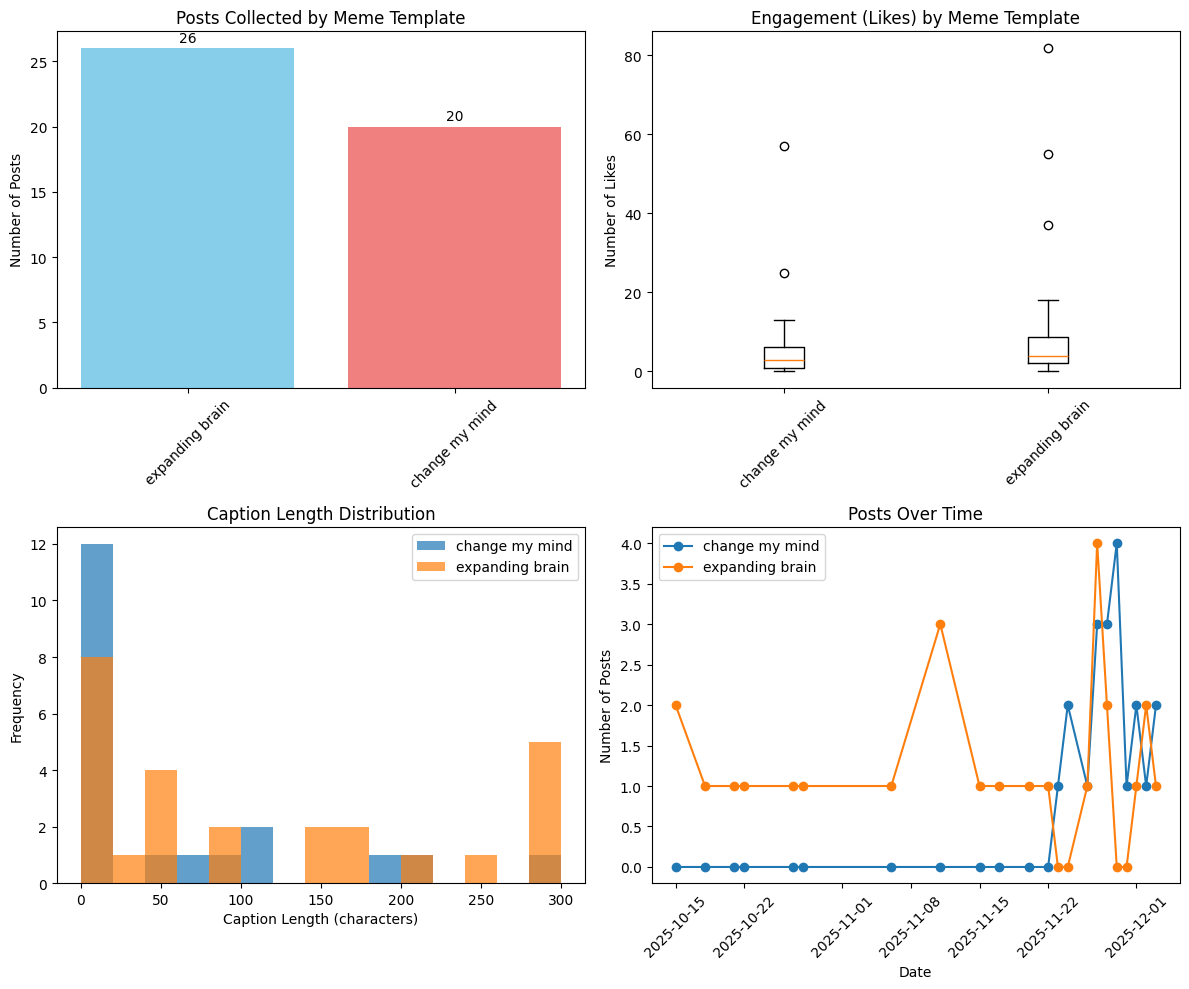

✅ Visualization saved to 'images/data_collection_summary.png'

📋 SUMMARY STATISTICS:
Total posts collected: 46
Posts with images downloaded: 46

--- CHANGE MY MIND ---
  Count: 20
  Avg likes: 7.4
  Avg reposts: 0.5
  Avg caption length: 58.0 chars
  Unique authors: 20

--- EXPANDING BRAIN ---
  Count: 26
  Avg likes: 11.4
  Avg reposts: 1.3
  Avg caption length: 117.3 chars
  Unique authors: 21


In [29]:
# STEP 3: Visualize our collected data
import matplotlib.pyplot as plt

if 'df_focused' in locals() and not df_focused.empty:
    print("\n📊 VISUALIZING COLLECTED DATA")
    print("=============================")
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Posts by template
    template_counts = df_focused['meme_template'].value_counts()
    axes[0, 0].bar(template_counts.index, template_counts.values, color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Posts Collected by Meme Template')
    axes[0, 0].set_ylabel('Number of Posts')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for i, v in enumerate(template_counts.values):
        axes[0, 0].text(i, v + 0.5, str(v), ha='center')
    
    # 2. Engagement by template (boxplot)
    engagement_data = []
    template_labels = []
    
    for template in TARGET_TEMPLATES:
        template_data = df_focused[df_focused['meme_template'] == template]
        if not template_data.empty:
            engagement_data.append(template_data['likes'].values)
            template_labels.append(template)
    
    axes[0, 1].boxplot(engagement_data, labels=template_labels)
    axes[0, 1].set_title('Engagement (Likes) by Meme Template')
    axes[0, 1].set_ylabel('Number of Likes')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Caption length distribution
    df_focused['caption_length'] = df_focused['caption'].apply(lambda x: len(str(x)))
    
    for i, template in enumerate(TARGET_TEMPLATES):
        template_data = df_focused[df_focused['meme_template'] == template]
        if not template_data.empty:
            axes[1, 0].hist(template_data['caption_length'], alpha=0.7, label=template, bins=15)
    
    axes[1, 0].set_title('Caption Length Distribution')
    axes[1, 0].set_xlabel('Caption Length (characters)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # 4. Post timeline (if we have dates)
    try:
        df_focused['created_date'] = pd.to_datetime(df_focused['created_at']).dt.date
        
        timeline_data = df_focused.groupby(['created_date', 'meme_template']).size().unstack(fill_value=0)
        
        for template in TARGET_TEMPLATES:
            if template in timeline_data.columns:
                axes[1, 1].plot(timeline_data.index, timeline_data[template], marker='o', label=template)
        
        axes[1, 1].set_title('Posts Over Time')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Number of Posts')
        axes[1, 1].legend()
        axes[1, 1].tick_params(axis='x', rotation=45)
        
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f"Could not plot timeline:\n{e}", 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Posts Over Time (Data Unavailable)')
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'data_collection_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualization saved to 'images/data_collection_summary.png'")
    
    # Summary statistics
    print("\n📋 SUMMARY STATISTICS:")
    print(f"Total posts collected: {len(df_focused)}")
    print(f"Posts with images downloaded: {df_focused['image_path'].notna().sum()}")
    
    for template in TARGET_TEMPLATES:
        template_df = df_focused[df_focused['meme_template'] == template]
        if not template_df.empty:
            print(f"\n--- {template.upper()} ---")
            print(f"  Count: {len(template_df)}")
            print(f"  Avg likes: {template_df['likes'].mean():.1f}")
            print(f"  Avg reposts: {template_df['reposts'].mean():.1f}")
            print(f"  Avg caption length: {template_df['caption_length'].mean():.1f} chars")
            print(f"  Unique authors: {template_df['author_handle'].nunique()}")

## 3. Load processed data

In [ ]:

# In the final project, you will provide cleaned CSV files in data/processed.
# Here we load them; if they do not exist yet, we show an empty DataFrame
# so that the notebook can still run without errors.

reddit_path = PROCESSED_DIR / "reddit_memes.csv"
bluesky_path = PROCESSED_DIR / "bluesky_memes.csv"

if reddit_path.exists():
    reddit_df = pd.read_csv(reddit_path)
else:
    reddit_df = pd.DataFrame()
    print("WARNING: reddit_memes.csv not found in data/processed. Using empty DataFrame.")

if bluesky_path.exists():
    bluesky_df = pd.read_csv(bluesky_path)
else:
    bluesky_df = pd.DataFrame()
    print("WARNING: bluesky_memes.csv not found in data/processed. Using empty DataFrame.")

print("Reddit shape:", reddit_df.shape)
print("Bluesky shape:", bluesky_df.shape)



## 4. Data cleaning and harmonization

Goals:

- Merge Reddit and Bluesky into a unified schema.  
- Standardize timestamp format.  
- Create unified fields for:
  - `caption` (title/text)  
  - `image_url`  
  - `likes`, `comments`, `shares` (or platform equivalents)  
  - `platform`  

We also filter to posts that actually contain images and belong to the meme templates of interest.


In [ ]:

# Example harmonization skeleton

def unify_reddit(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["platform"] = "reddit"
    out["caption"] = out["title"].fillna("") + " " + out["selftext"].fillna("")
    out["image_url"] = out["url"]
    out["likes"] = out["score"]
    out["comments"] = out["num_comments"]
    out["shares"] = np.nan  # Reddit has no explicit "shares"
    out["created_at"] = pd.to_datetime(out["created_utc"], unit="s")
    return out[["platform", "caption", "image_url", "likes", "comments", "shares", "created_at"]]

def unify_bluesky(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["platform"] = "bluesky"
    out["caption"] = out["text"]
    out["image_url"] = out.get("image_urls", "")
    out["likes"] = out.get("like_count", np.nan)
    out["comments"] = out.get("reply_count", np.nan)
    out["shares"] = out.get("repost_count", np.nan)
    out["created_at"] = pd.to_datetime(out["created_at"])
    return out[["platform", "caption", "image_url", "likes", "comments", "shares", "created_at"]]

unified_frames = []
for df, fn in [(reddit_df, unify_reddit), (bluesky_df, unify_bluesky)]:
    unified_frames.append(fn(df))

full_df = pd.concat(unified_frames, ignore_index=True) if unified_frames else pd.DataFrame()
print("Unified dataset shape:", full_df.shape)
full_df.head()



## 5. Image download and caching

We download each meme image to `images/` and keep a mapping from post ID to local file path.

This enables:

- reproducible CLIP embeddings  
- offline analysis  
- visual inspection per template cluster


In [ ]:

import hashlib
import requests

def download_image(url: str, dest_dir: Path) -> Path | None:
    if not isinstance(url, str) or not url.startswith("http"):
        return None
    fname = hashlib.md5(url.encode("utf-8")).hexdigest() + ".jpg"
    fpath = dest_dir / fname
    if fpath.exists():
        return fpath
    try:
        resp = requests.get(url, timeout=10)
        resp.raise_for_status()
        with open(fpath, "wb") as f:
            f.write(resp.content)
        return fpath
    except Exception as e:
        # In the final project you may log this instead of printing
        print("Failed to download", url, "->", e)
        return None

if not full_df.empty and "image_url" in full_df.columns:
    local_paths = []
    for url in full_df["image_url"]:
        local_paths.append(download_image(url, IMAGES_DIR))
    full_df["image_path"] = local_paths
else:
    print("No image URLs available yet; skipping download step.")



## 6. Image embeddings and template clustering

We use a pre-trained CLIP model to obtain an embedding vector for each meme image,  
then cluster memes into template-like groups using k-means.

Later, we will label clusters with interpretable template names (e.g., "change my mind").


In [ ]:

CLIP_ENABLED = False  # set to True when dependencies and GPU/CPU resources are available

if CLIP_ENABLED and not full_df.empty and "image_path" in full_df.columns:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    embed_list = []
    valid_idx = []
    for idx, path in enumerate(full_df["image_path"]):
        if path and isinstance(path, str) and os.path.exists(path):
            image = Image.open(path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                emb = model.get_image_features(**inputs)
            embed_list.append(emb.cpu().numpy().flatten())
            valid_idx.append(idx)

    if embed_list:
        embeds = np.vstack(embed_list)
        n_clusters = 8  # adjust after exploration
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(embeds)

        full_df.loc[valid_idx, "template_cluster"] = cluster_labels
    else:
        print("No embeddings computed (no valid images).")
else:
    print("CLIP embedding step disabled or no images available.")


### 6.1 Cluster visualization (t-SNE / example images)

In [ ]:

# TODO: After computing template_cluster, create:
# - t-SNE scatter plot colored by cluster
# - montage of example images per cluster

# Example placeholder for t-SNE:
if not full_df.empty and "template_cluster" in full_df.columns:
    print("Template clusters available. Add t-SNE visualization here.")
else:
    print("Template clusters not yet computed.")



## 7. Caption processing, sentiment and framing

Here we:

- Clean captions (lowercase, remove URLs, etc.)  
- Compute sentiment scores (e.g., using VADER).  
- Derive simple framing features:
  - presence of question marks / exclamations  
  - first-person vs. third-person pronouns  
  - political vs. non-political keywords  
- (Optional) Use topic modeling or more advanced framing classifiers.


In [ ]:

import re

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

if not full_df.empty:
    full_df["caption_clean"] = full_df["caption"].apply(basic_clean)
else:
    print("Unified dataset empty; skipping caption cleaning.")


In [ ]:

# Sentiment analysis with VADER (if available)
try:
    nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    try:
        nltk.download("vader_lexicon")
    except Exception as e:
        print("Could not download VADER lexicon:", e)

if not full_df.empty:
    try:
        sia = SentimentIntensityAnalyzer()
        sentiment_scores = full_df["caption_clean"].apply(lambda t: sia.polarity_scores(t)["compound"])
        full_df["sentiment"] = sentiment_scores
    except Exception as e:
        print("Sentiment analysis failed:", e)
else:
    print("Unified dataset empty; skipping sentiment computation.")


In [ ]:

# Simple framing features (placeholder)
if not full_df.empty:
    full_df["has_question"] = full_df["caption_clean"].str.contains("\?")
    full_df["has_exclaim"] = full_df["caption_clean"].str.contains("!")
    full_df["length_tokens"] = full_df["caption_clean"].str.split().apply(len)

    # Example: detect potentially political captions using keyword list
    political_keywords = ["election", "president", "government", "policy", "vote"]
    pattern = "|".join(political_keywords)
    full_df["is_political"] = full_df["caption_clean"].str.contains(pattern)
else:
    print("Unified dataset empty; skipping framing features.")



## 8. Virality metrics

We operationalize **virality** as a function of:

- Likes / upvotes  
- Comments / replies  
- Shares / reposts  
- (Optional) Time-normalized variants (e.g., score per hour)

We then examine how virality varies across:

- meme templates (clusters)  
- caption sentiment and framing features  
- platforms (Reddit vs Bluesky)


In [ ]:

if not full_df.empty:
    # Example composite virality score (you may refine this):
    def compute_virality(row):
        likes = row.get("likes", 0) or 0
        comments = row.get("comments", 0) or 0
        shares = row.get("shares", 0) or 0
        return likes + 2*comments + 3*shares

    full_df["virality_raw"] = full_df.apply(compute_virality, axis=1)

    # Log-transform to reduce skew
    full_df["virality_log1p"] = np.log1p(full_df["virality_raw"])
else:
    print("Unified dataset empty; skipping virality computation.")



## 9. Modeling: how template and caption framing influence virality

We fit simple models to understand joint effects of:

- Template cluster  
- Sentiment  
- Framing features  
- Platform  

on virality.

Possible approaches:

- Linear regression / regularized regression  
- Mixed-effects models (platform as random effect)  
- Tree-based models (e.g., RandomForestRegressor)  

Below we show a basic regression skeleton.


In [ ]:

try:
    from sklearn.linear_model import LinearRegression
except ImportError:
    print("scikit-learn not installed; install it to run the regression.")
else:
    if not full_df.empty and "virality_log1p" in full_df.columns:
        model_df = full_df.dropna(subset=["virality_log1p"]).copy()

        # Create simple numeric features
        model_df["platform_is_reddit"] = (model_df["platform"] == "reddit").astype(int)
        model_df["template_cluster"] = model_df.get("template_cluster", -1).fillna(-1).astype(int)

        feature_cols = [
            "platform_is_reddit",
            "template_cluster",
            "sentiment",
            "has_question",
            "has_exclaim",
            "is_political",
            "length_tokens",
        ]

        # Convert booleans to ints
        for col in ["has_question", "has_exclaim", "is_political"]:
            if col in model_df.columns:
                model_df[col] = model_df[col].astype(int)

        X = model_df[feature_cols].fillna(0)
        y = model_df["virality_log1p"]

        if len(model_df) > 10:
            reg = LinearRegression()
            reg.fit(X, y)
            print("Fitted LinearRegression with coefficients:")
            for col, coef in zip(feature_cols, reg.coef_):
                print(f"  {col}: {coef:.3f}")
        else:
            print("Not enough data points to fit a regression model.")
    else:
        print("No virality data available for modeling.")



## 10. Main figures and tables

This section should reproduce all main figures, charts and tables used in the paper, such as:

1. Distribution of virality by platform  
2. Sentiment vs. virality  
3. Template cluster vs. virality  
4. Interaction plots (e.g., sentiment–virality by platform)  
5. Example memes per template cluster (qualitative case studies)

Below we include placeholders for you to fill with the actual visualizations.


In [ ]:

# 10.1 Virality distributions by platform
if not full_df.empty and "virality_log1p" in full_df.columns:
    full_df.boxplot(column="virality_log1p", by="platform")
    plt.title("Virality (log1p) by platform")
    plt.suptitle("")
    plt.xlabel("Platform")
    plt.ylabel("log1p(virality)")
    plt.show()
else:
    print("No virality data available for plotting.")


In [ ]:

# 10.2 Sentiment vs. virality scatter (placeholder)
if not full_df.empty and "sentiment" in full_df.columns and "virality_log1p" in full_df.columns:
    plt.scatter(full_df["sentiment"], full_df["virality_log1p"], alpha=0.3)
    plt.xlabel("Sentiment (compound)")
    plt.ylabel("log1p(virality)")
    plt.title("Sentiment vs. virality")
    plt.show()
else:
    print("Sentiment or virality not available for plotting.")



## 11. Qualitative case studies

Here you can:

- Show a small set of example memes from key template clusters  
- Compare how the **same template** is used on Reddit vs. Bluesky  
- Discuss differences in caption framing and user reaction  

You can use `IPython.display.display(Image(...))` to show example images.


In [ ]:

# TODO: Implement helper to display example memes per cluster / platform.
# from IPython.display import display
# display(Image(filename=some_path))



## 12. Limitations and ethical considerations

In this markdown cell, discuss:

- Sampling biases (which subreddits / hashtags you used)  
- API limitations (rate limits, deleted posts, etc.)  
- Representativeness of Reddit and Bluesky users  
- Potential ethical issues (e.g., sensitive content, privacy)  
- Constraints of using automated sentiment / framing models on memes



## 13. Summary and link to paper

Summarize the main findings that this notebook reproduces, in a few bullet points:

- How visual templates relate to virality  
- How caption framing and sentiment relate to virality  
- Key differences between Reddit and Bluesky  

Reference the corresponding sections / figures in your paper so graders can easily cross-check.
